### Holdout-method

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.preprocessing import sequence
from keras.datasets import imdb
from keras import layers, models
from keras.models import Sequential
from keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import random
from keras import optimizers
from keras.layers import SimpleRNN, Dense, Dropout
from keras.layers import Bidirectional
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import os
import sys
import argparse
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import pprint
import pydot
import graphviz
plt.rcParams["font.family"] = "TakaoGothic"
plt.rc('figure',figsize=[8.0, 4.8])

In [2]:
def make_label(text):
    with open("label.txt", "w") as f:
         f.write(text)
    f.close()

In [3]:
def rm_zero_sequences_endlist(txtlist):
    numbers = txtlist
    if (numbers[-1] ==0 and numbers[-2] ==0 and numbers[-3] ==0 and numbers[-4] ==0 and numbers[-5] ==0 and numbers[-6] ==0
    and numbers[-7] ==0 and numbers[-8] ==0 and numbers[-9] ==0 and numbers[-10] ==0 and numbers[-11] ==0 and numbers[-12] ==0
    and numbers[-13] ==0 and numbers[-14] ==0 and numbers[-15] ==0 and numbers[-16] ==0 and numbers[-17] ==0 and numbers[-18] ==0
    and numbers[-19] ==0 and numbers[-20] ==0 and numbers[-21] ==0 and numbers[-22] ==0 and numbers[-23] ==0 and numbers[-24] ==0
    and numbers[-25] ==0 and numbers[-26] ==0 and numbers[-27] ==0 and numbers[-28] ==0 and numbers[-29] ==0 and numbers[-30] ==0
    and numbers[-31] ==0 and numbers[-32] ==0 and numbers[-33] ==0 and numbers[-34] ==0 and numbers[-35] ==0 and numbers[-36] ==0
    and numbers[-37] ==0 and numbers[-38] ==0 and numbers[-39] ==0 and numbers[-40] ==0 and numbers[-41] ==0 and numbers[-42] ==0):
        numbers = numbers[:-42]
    return numbers

#### 設定

In [4]:
#TRAIN OPTION
framesize  = 19320  #23-*84 18900
inputshape = 230   #126(180) #70(100) 35(50)
epoch      = 300
batchsize  = 40
model_note = 'LSTM'
tenb_path  = './SaveData/logs/' + model_note
save_path  = 'SaveData/'+ model_note +'/'
os.makedirs(save_path,exist_ok=True)

traindata  = '../../DATASET/Train/Zero/0.6/AbsoluteTRAIN/'
valdata    = '../../DATASET/Train/Zero/0.6/AbsoluteVAL/'
#TEST OPTION
testdatadir= '../../DATASET/Train/Zero/0.6/AbsoluteTEST/'
classname  = ['おはよう','どういたしまして','好き','嫌い','おめでとう','新しい','こんばんは','久しぶり','ありがとう','元気','自由','ウサギ','負け']

In [5]:
def build_model(label):
    model = Sequential()
    model.add(layers.LSTM(256, return_sequences=True,input_shape=(inputshape, 84))) 
    #model.add(layers.LSTM(512, return_sequences=True))
    #model.add(layers.LSTM(256, return_sequences=True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(label, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

#### 検証アリ

In [6]:
def load_data(dirname):
    if dirname[-1]!='/':
        dirname=dirname+'/'
    listfile=os.listdir(dirname) #入出力のファイルリスト
    X = []
    Y = []
    for file in listfile: #単語名を検出
        if "_" in file:   #ビデオファイルを無視
            continue
        wordname=file 
        textlist=os.listdir(dirname+wordname)  # テキストファイルリスト
        k=0
        for text in textlist: #
            if "DS_" in text:
                continue
            textname=dirname+wordname+"/"+text
            numbers=[]
            #print(textname)
            with open(textname, mode = 'r') as t:
                numbers = [float(num) for num in t.read().split()] #テキストファイル内のポイントを切り取り
                #print(len(numbers))
                while numbers[0] == 0:
                    numbers = numbers[1:]
                for i in range(len(numbers),framesize): #50frame * 84 = 4200     60*3*84=15120  250*84=21000
                    numbers.extend([0.000]) 
            row=0
            landmark_frame=[]
            for i in range(0,inputshape): #100frame = 70, 50frame = 35     126
                landmark_frame.extend(numbers[row:row+84])
                row += 84
            #print(len(landmark_frame))
            landmark_frame=np.array(landmark_frame) #35*84*2 (5880,) 1dim
            landmark_frame=landmark_frame.reshape(-1,84) #(70,84) 2dim
            X.append(np.array(landmark_frame))         
            Y.append(wordname)
            
    X=np.array(X)
    Y=np.array(Y)
    
    tmp = [[x,y] for x, y in zip(X, Y)]
    random.shuffle(tmp)
    
    X = [n[0] for n in tmp]
    Y = [n[1] for n in tmp]
    
    k=set(Y)
    ks=sorted(k)
    text=""
    for i in ks:
        text=text+i+" "
    make_label(text)
    
    s = Tokenizer()
    s.fit_on_texts([text])
    encoded=s.texts_to_sequences([Y])[0]
    one_hot = to_categorical(encoded)
    

    (x_train, y_train) = X, one_hot
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    return x_train,y_train

In [7]:
def load_valdata(dirname):
    listfile=os.listdir(dirname)
    XT = []
    YT = []
    for file in listfile:
        if "_" in file:
            continue
        wordname=file
        textlist=os.listdir(dirname+wordname)
        for text in textlist:
            if "DS_" in text:
                continue
            textname=dirname+wordname+"/"+text
            numbers=[]
            with open(textname, mode = 'r') as t:
                numbers = [float(num) for num in t.read().split()]
                while numbers[0] == 0:
                    numbers = numbers[1:]
                for i in range(len(numbers),framesize):
                    numbers.extend([0.000]) 
            landmark_frame=[]
            row=0
            for i in range(0,inputshape):
                landmark_frame.extend(numbers[row:row+84])
                row += 84
            landmark_frame=np.array(landmark_frame)
            landmark_frame=landmark_frame.reshape(-1,84)
            XT.append(np.array(landmark_frame))
            YT.append(wordname)
    XT=np.array(XT)
    YT=np.array(YT)

    tmp1 = [[xt,yt] for xt, yt in zip(XT, YT)]
    random.shuffle(tmp1)

    XT = [n[0] for n in tmp1]
    YT = [n[1] for n in tmp1]
    
    k=set(YT)
    ks=sorted(k)
    text=""
    for i in ks:
        text=text+i+" "
    #make_label(text)
    
    s = Tokenizer()
    s.fit_on_texts([text])
    encoded1=s.texts_to_sequences([YT])[0]
    one_hot2=to_categorical(encoded1)
    
    (x_test,y_test)=XT,one_hot2
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    return x_test,y_test

#### モデル構築

#### メインプログラムトレーニングモデル

In [8]:
def main(traindirname,valdirname):  
    x_train,y_train=load_data(traindirname)
    x_test,y_test=load_valdata(valdirname)
    #num_val_samples=(x_train.shape[0])//5
    model=build_model(y_train.shape[1])
    print('Training stage')

    #Callbacks
    tb = TensorBoard(log_dir = tenb_path, histogram_freq=1, write_graph=True)
    cp = ModelCheckpoint(save_path+'model.h5', monitor='val_loss', verbose=0, mode = 'auto', save_best_only=True, save_weights_only=False)
    es = EarlyStopping(monitor='val_loss', patience=35, verbose=0, mode='auto', restore_best_weights=True)
    cbks = [tb,cp]   #tb,cp,es
    
    
    #history = model.fit(x_train, y_train, batch_size=batch_size, epochs = epochs, verbose=1, callbacks=cbks, validation_data=(x_test,y_test))
    history = model.fit(x_train, y_train, epochs=epoch, batch_size=batchsize, verbose=0, validation_data=(x_test,y_test), callbacks = cbks)
    print('_________________________________________________________________')
    print('Shape & history')
    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)
    
    # list all data in history
    print(history.history.keys())
    print('_________________________________________________________________')
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylim(0,1.1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(save_path+'accuracy.png', dpi=300)
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylim(0,3.0)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(save_path+'loss.png', dpi=300)
    plt.show()
    
    plot_model(model,show_shapes=True,to_file=save_path+'model.png',expand_nested=True,dpi=300)
    model.summary()
    print('_________________________________________________________________')
    print('Test stage')
     
    score = model.evaluate(x_test,y_test,batch_size=batchsize,verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    yhat = model.predict(x_test)
    clf_report = classification_report(np.argmax(y_test,axis=1), np.argmax(yhat, axis=1),target_names=classname,output_dict=True,digits=5)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T,  cmap="PuBu", annot=True, vmax=1, vmin=0, linecolor="white", linewidths=.5,xticklabels=True, yticklabels=True,fmt=".5f")
    plt.savefig(save_path+'train_classification.png',dpi=300,bbox_inches="tight")
    
    print('_________________________________________________________________')
    print('Shape & history')
    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 230, 256)          349184    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
Total params: 548,110
Trainable params: 548,110
Non-trainable params: 0
_________________________________________________________________
Training stage
_________________________________________________________________
Shape & history
(1300, 230, 84) (260, 230, 84)
(1300, 14) (260, 14)
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
_________________________________________________________________


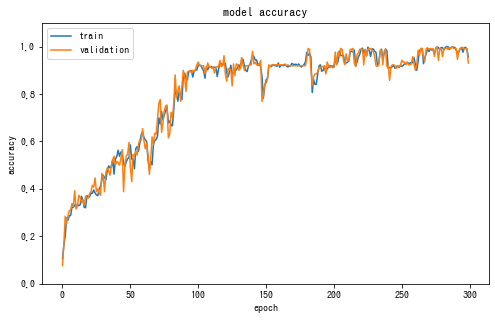

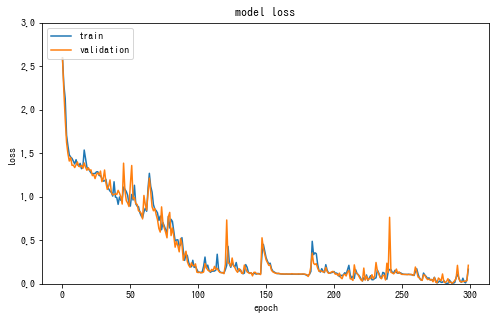

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 230, 256)          349184    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
Total params: 548,110
Trainable params: 548,110
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Test stage
Test loss: 0.21271051466464996
Test accuracy: 0.9307692050933838
_________________________________________________________________
Shape & history
(1300, 230, 84) (260, 230, 84)
(1300, 14) (260, 14)


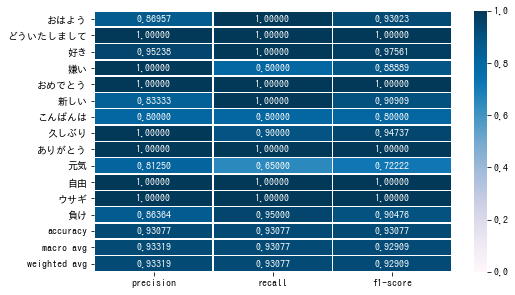

In [9]:
main(traindata,valdata)

#### Confusion matrix on test set (テストセット混同行列)

In [10]:
def load_testdata(dirname):
    listfile=os.listdir(dirname)
    XT = []
    YT = []
    for file in listfile:
        if "_" in file:
            continue
        wordname=file
        textlist=os.listdir(dirname+wordname)
        for text in textlist:
            if "DS_" in text:
                continue
            textname=dirname+wordname+"/"+text
            numbers=[]
            with open(textname, mode = 'r') as t:
                numbers = [float(num) for num in t.read().split()]
                while numbers[0] == 0:
                    numbers = numbers[1:]
                for i in range(len(numbers),framesize):
                    numbers.extend([0.000]) 
            landmark_frame=[]
            row=0
            for i in range(0,inputshape):
                landmark_frame.extend(numbers[row:row+84])
                row += 84
            landmark_frame=np.array(landmark_frame)
            landmark_frame=landmark_frame.reshape(-1,84)
            XT.append(np.array(landmark_frame))
            YT.append(wordname)
    XT=np.array(XT)
    YT=np.array(YT)

    tmp1 = [[xt,yt] for xt, yt in zip(XT, YT)]
    random.shuffle(tmp1)

    XT = [n[0] for n in tmp1]
    YT = [n[1] for n in tmp1]
    
    k=set(YT)
    ks=sorted(k)
    text=""
    for i in ks:
        text=text+i+" "
    #make_label(text)
    
    s = Tokenizer()
    s.fit_on_texts([text])
    encoded1=s.texts_to_sequences([YT])[0]
    one_hot2=to_categorical(encoded1)
    
    (x_test,y_test)=XT,one_hot2
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    return x_test,y_test

In [11]:
dirname = testdatadir
x_test,y_test=load_testdata(dirname)
new_model = tf.keras.models.load_model(save_path+'model.h5')
new_model.summary()

print('Test stage')
score = new_model.evaluate(x_test,y_test,batch_size=batchsize,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('_________________________________________________________________')
print('Shape & history')
print(x_test.shape)
print(y_test.shape)

xhat = x_test
yhat = new_model.predict(xhat)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 230, 256)          349184    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
Total params: 548,110
Trainable params: 548,110
Non-trainable params: 0
_________________________________________________________________
Test stage
Test loss: 0.029196811839938164
Test accuracy: 0.9913461804389954
_________________________________________________________________
Shape & history
(1040, 230, 84)
(1040, 14)


In [12]:
print(yhat)
print(yhat.shape)

[[5.7104517e-09 2.0141011e-08 6.9191164e-09 ... 1.2609527e-04
  3.3660004e-07 1.8677953e-07]
 [4.3253689e-07 8.1340107e-04 6.6650609e-05 ... 3.2553002e-05
  2.9524068e-05 7.2301204e-06]
 [4.9941667e-07 1.5542186e-03 4.6232042e-05 ... 3.2841661e-05
  3.5244073e-05 7.2720954e-06]
 ...
 [4.7479718e-11 1.6076135e-09 1.0981420e-07 ... 6.2346643e-08
  1.5323012e-07 3.2906153e-09]
 [2.9892017e-10 1.2102700e-09 7.0401313e-07 ... 3.2380497e-06
  2.7541732e-08 2.1549427e-07]
 [2.5555948e-08 7.2116042e-09 6.4190971e-07 ... 4.8275542e-08
  2.2488859e-07 2.5959822e-05]]
(1040, 14)


In [13]:
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.PuBu,linecolor="white", linewidths=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=40)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 30)
    plt.yticks(tick_marks, classes, fontsize = 30)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 25)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 25)
    plt.xlabel('Predicted label', fontsize = 25)
    plt.savefig(save_path+'matrix.png', dpi=300)

In [15]:
cfm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat, axis=1))

In [16]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[80  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5 75  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 78  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0 79  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 79  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 80]]


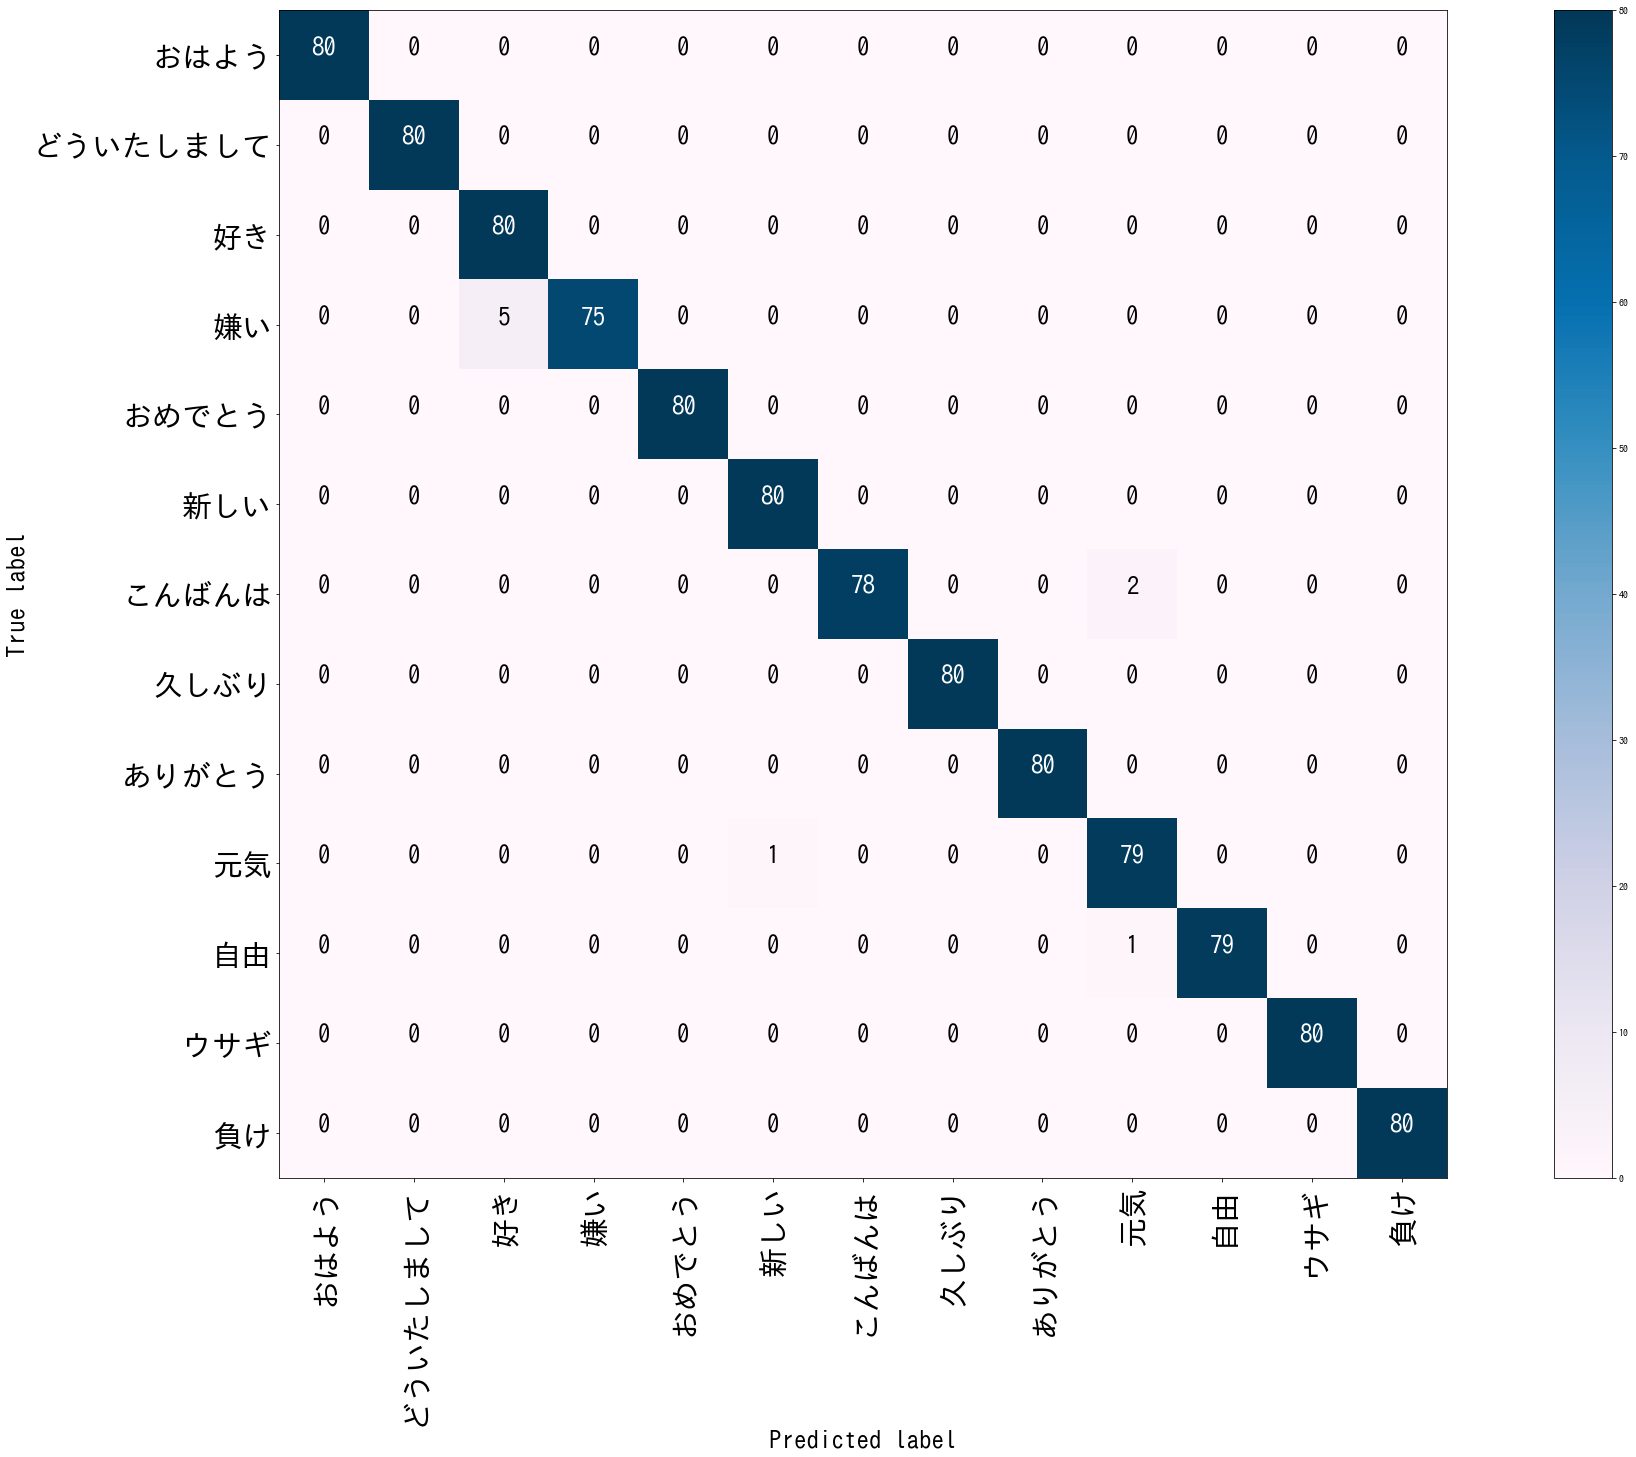

In [17]:
plt.figure(figsize=(30,20))
class_names = classname

plot_confusion_matrix(cfm, classes=class_names, title='')
plt.show()

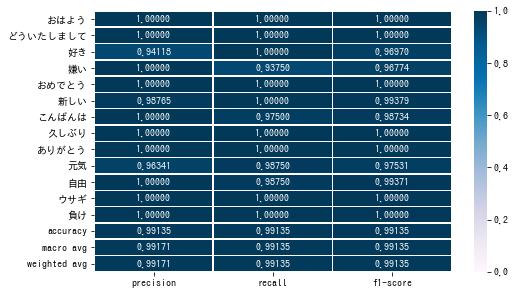

In [18]:
clf_report = classification_report(np.argmax(y_test,axis=1), np.argmax(yhat, axis=1),target_names=classname,output_dict=True,digits=5)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T,  cmap="PuBu", annot=True, vmax=1, vmin=0, linecolor="white", linewidths=.5,xticklabels=True, yticklabels=True,fmt=".5f")

plt.savefig(save_path+'classification.png',dpi=300,bbox_inches="tight")